In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import robust_scale
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN

sns.set_theme(context="notebook", style="ticks")

Load data

In [2]:
data = pd.read_csv(
    filepath_or_buffer="data\\marketing_campaign.csv", 
    sep="\t", 
    parse_dates=["Dt_Customer"]
)

data = data.fillna(0)

data_original = data

Replace values

In [3]:
data.set_index("ID", inplace=True)
data.replace(
    to_replace={
        "YOLO": "Single",
        "Absurd": "Single",
        "Alone": "Single",
        "Together": "Married"},
        inplace=True
)

data["Kidhome"] += data["Teenhome"]
data.drop("Teenhome", axis=1, inplace=True)
data["Dt_Customer"] = data["Dt_Customer"].view("int64")

In [4]:
money_spent_total = (
    data["MntWines"] +
    data["MntFruits"] +
    data["MntMeatProducts"] + 
    data["MntFishProducts"] + 
    data["MntSweetProducts"] + 
    data["MntGoldProds"]
)

# data["MntTotal"] = money_spent_total

Encode and drop categorical features

In [5]:
Education_categories = ["Basic", "Graduation", "2n Cycle", "Master", "PhD"]

ordinal_enc = OrdinalEncoder(
    categories=[Education_categories],
    dtype="int"
)

oh_enc = OneHotEncoder(
    sparse=False,
    dtype="int")

ordinals = pd.DataFrame(ordinal_enc.fit_transform(
    X=np.array(data.Education).reshape(-1, 1))).set_index(data.index)
one_hots = pd.DataFrame(oh_enc.fit_transform(
    X=np.array(data["Marital_Status"]).reshape(-1, 1))).set_index(data.index)

data = pd.concat([data, ordinals, one_hots], axis=1)
data = data.drop(labels=["Education", "Marital_Status"], axis=1)
data = robust_scale(data)

Map to two dimensions

In [93]:
reducer = UMAP(
    n_components=4,
    min_dist=0,
    n_neighbors=130,
    densmap=True,
    metric="euclidean",
    target_metric="euclidean",
    # output_metric="cosine",
    random_state=42
)

embedding = reducer.fit_transform(
    X=data,
    y=robust_scale(money_spent_total)
)

<AxesSubplot:>

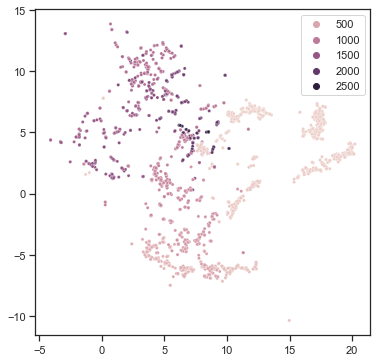

In [94]:
plt.figure(figsize=(6,6))

sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    s=10,
    hue=money_spent_total
)

In [100]:
clusterer = HDBSCAN(
    min_cluster_size=150,
    min_samples=5,
    # metric="cosine"
)

clusters = clusterer.fit_predict(embedding)

<AxesSubplot:>

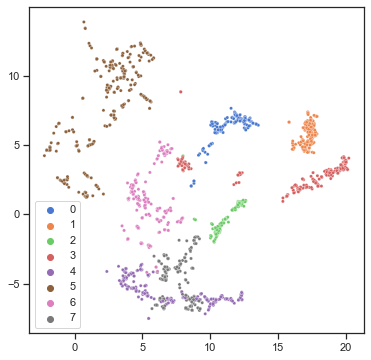

In [101]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=embedding[:,0][clusters!=-1],
    y=embedding[:,1][clusters!=-1],
    alpha="auto",
    s=10,
    hue=clusters[clusters!=-1],
    palette="muted",
    # color="gray"
)

In [102]:
data_original.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

<AxesSubplot:xlabel='MntWines', ylabel='Count'>

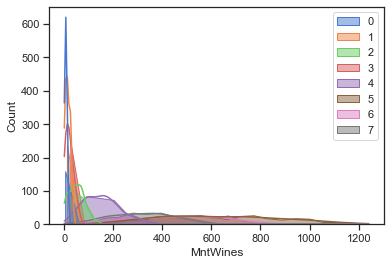

In [103]:
# data_original.Income += 1
sns.histplot(
    data=data_original[clusters!=-1],
    x="MntWines",
    # x=money_spent_total[clusters!=-1],
    # y=money_spent_total[clusters!=-1],
    hue=clusters[clusters!=-1],
    multiple="dodge",
    palette="muted",
    # bins=50,
    element="poly",
    # discrete=True,
    kde=True
    # log_scale=True
)

In [104]:
data_original.Z_CostContact.unique()

array([3], dtype=int64)